In [6]:
from src.core import DataLoader

In [7]:
dl = DataLoader('data/jokes.csv', 'data/rating.csv')

In [8]:
from scipy.sparse import csr_matrix

In [9]:
from scipy.sparse import csr_matrix
import numpy as np

from sklearn.metrics.pairwise import linear_kernel

In [10]:
df = dl.train_data

In [11]:
N = len(df['user_id'].unique())
M = len(df['joke_id'].unique())

user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
joke_mapper = dict(zip(np.unique(df["joke_id"]), list(range(M))))

user_index = [user_mapper[i] for i in df['user_id']]
joke_index = [joke_mapper[i] for i in df['joke_id']]

X = csr_matrix((df["Rating"], (joke_index, user_index)), shape=(M, N))

In [12]:
test = dl.test_data

In [13]:
pop = dl.train_data.groupby('joke_id').mean()

In [14]:
import numpy as np
import pandas as pd

In [15]:
import math

err = 0
err_pop = 0
t = 0

M = X.transpose().toarray()
M_presence = M != 0

taken_l = []
data_l = []

for r in test[:1000].iterrows():
    joke_id = r[1]['joke_id'] - 1
    user_id = r[1]['user_id'] - 1

    sm = 0
    wg = 0

    row = M[user_id, :]
    row_presence = row != 0
    
    P = (M_presence | np.repeat(row_presence.reshape((1, row.shape[0])), M.shape[0], 0)).astype(int)
    D = np.sum(M * np.repeat(row.reshape((1, row.shape[0])), M.shape[0], 0), 1)
    N = np.linalg.norm(M * P, 2, 1) * np.linalg.norm(row * row_presence, 2)
    C_map = np.abs(D / N)
    C_map[np.isnan(C_map)] = 0
    
    C = X[joke_id, :].toarray()[0, :]
    D = C.nonzero()[0]
    taken = 0
    
    for ind in D:
        sim = C_map[ind]
        
        if sim > 0.2:
            sm += sim * M[ind, joke_id]
            wg += sim
            taken += 1
        
    pred = sm / wg if wg > 0 else 0
    e = abs(pred - r[1]['Rating'])
    e_p = abs(pop.loc[joke_id + 1]['Rating'] - r[1]['Rating'])
    err += e
    err_pop += e_p
    t += 1
    
    taken_l.append(taken)
    data_l.append(e)

/var/folders/20/c9bztpfs1_3c5ylxgnmkqsz00000gn/T/ipykernel_6882/3603431326.py:26: RuntimeWarning: invalid value encountered in true_divide
  C_map = np.abs(D / N)


In [16]:
err / t

3.940672276106694

In [17]:
err_pop / t

4.185828192057924

In [88]:
plot_df = pd.DataFrame(data={'Opinions': taken_l, 'Err': data_l})

plot_df

,Opinions,Err
0,1733,3.849634
1,825,5.051506
2,402,5.326866
3,386,1.002493
4,1212,1.425755
...,...,...
995,3819,7.727839
996,403,0.238012
997,119,4.318748
998,2355,5.571785


In [89]:
plot_df['opinion_bin'] = pd.cut(plot_df['Opinions'], bins=[300 * i for i in range(30)], labels=[300 * i for i in range(29)])

<AxesSubplot:xlabel='opinion_bin'>

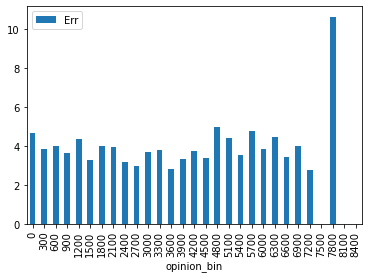

In [90]:
plot_df.groupby('opinion_bin').mean().plot.bar(y='Err')

In [1]:
from src.full_text_models import BertCosineModel, FullPreprocessingTFIDFCosineModel
from src.models.collaborative_filtering import CollaborativeFilteringModel

from src.core import Environment, DataLoader

In [2]:
dl = DataLoader('data/jokes.csv', 'data/rating.csv')

In [3]:
model = CollaborativeFilteringModel()

In [4]:
env = Environment(dl, model)

In [5]:
env.run()

/Users/lukasikm/PycharmProjects/WTUM_joke_rating_prediction/src/models/collaborative_filtering.py:34: RuntimeWarning: invalid value encountered in true_divide
  C_map = np.abs(D / N)


Explained variance score: 0.13461457401839272
Mean absolute error: 3.873382278716714
Mean squared error: 23.52309007901426
Median absolute error: 3.2861883327026877
R2 coefficient: 0.1308095527890245
